In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.model_selection import cross_val_score
import numpy as np

## Data Preparation

In [2]:
dataset = pd.read_excel('dataset.xlsx', index_col=0)

### Replace column values that should be empty for NaN

In [3]:
dataset['Urine - pH'].replace('Não Realizado', np.nan, inplace=True)

In [4]:
dataset['Urine - pH'] = dataset['Urine - pH'].astype('float64')

In [5]:
dataset.replace('not_done', np.nan, inplace=True)

### Replace Leukocytes' values '<1000' for 999

In [6]:
dataset['Urine - Leukocytes'].replace('<1000', '999', inplace=True)
dataset['Urine - Leukocytes'] = dataset['Urine - Leukocytes'].astype('float64')

### Replace True and False values for 0 and 1

In [7]:
dataset.replace('not_detected', 0, inplace=True)
dataset.replace('detected', 0, inplace=True)
dataset.replace('negative', 0, inplace=True)
dataset.replace('positive', 1, inplace=True)
dataset.replace('absent', 0, inplace=True)
dataset.replace('present', 1, inplace=True)

### Label Encoding

In [8]:
df_temp = dataset[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']].astype("str").apply(LabelEncoder().fit_transform)
dataset[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']] = df_temp.where(~dataset[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']].isna(), dataset[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']])

In [9]:
dataset['Urine - Aspect'] = dataset['Urine - Aspect'].astype("float64")
dataset['Urine - Urobilinogen'] = dataset['Urine - Urobilinogen'].astype("float64")
dataset['Urine - Crystals'] = dataset['Urine - Crystals'].astype("float64")
dataset['Urine - Color'] = dataset['Urine - Color'].astype("float64")

### Drop unnecessary columns

In [10]:
dataset.drop(columns=['Patient addmited to regular ward (1=yes, 0=no)',
                      'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                      'Patient addmited to intensive care unit (1=yes, 0=no)'], inplace=True)

## Analysis of missing data

In [11]:
def plot_missing_data(missing_data, title):
    f, ax = plt.subplots(figsize=(15, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=missing_data.index, y=missing_data['Percent'])
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title(title, fontsize=15)

In [12]:
def get_missing_data(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

,Total,Percent
Mycoplasma pneumoniae,5644,1.000000
Urine - Nitrite,5644,1.000000
Urine - Sugar,5644,1.000000
Partial thromboplastin time (PTT),5644,1.000000
"Prothrombin time (PT), Activity",5644,1.000000
D-Dimer,5644,1.000000
Fio2 (venous blood gas analysis),5643,0.999823
Vitamin B12,5641,0.999468
Lipase dosage,5636,0.998583
Albumin,5631,0.997697


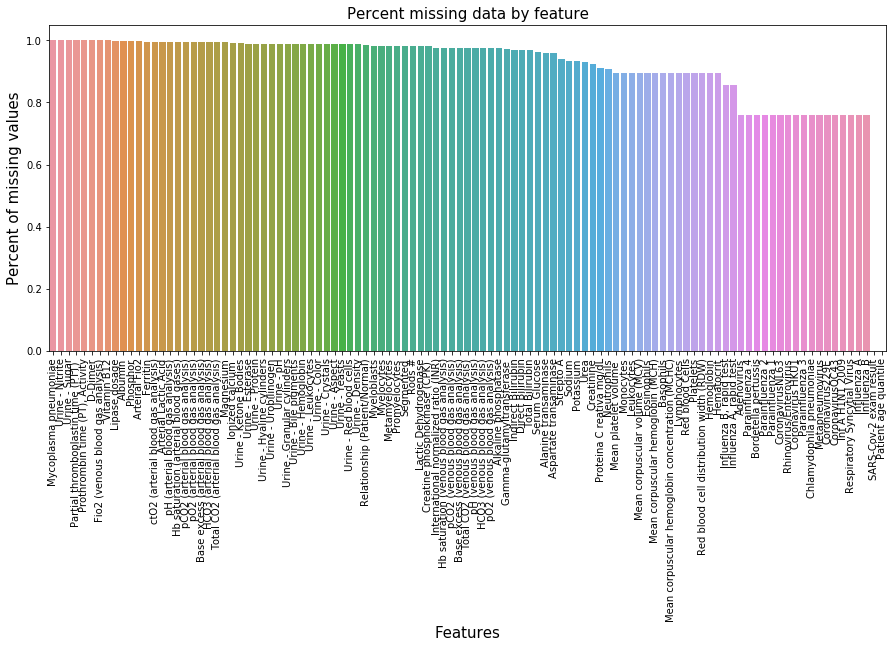

In [13]:
missing_data = get_missing_data(dataset)
plot_missing_data(missing_data, 'Percent missing data by feature')
missing_data.head(10)

,Total,Percent
Fio2 (venous blood gas analysis),558,1.000000
D-Dimer,558,1.000000
Urine - Nitrite,558,1.000000
Partial thromboplastin time (PTT),558,1.000000
"Prothrombin time (PT), Activity",558,1.000000
Vitamin B12,558,1.000000
Mycoplasma pneumoniae,558,1.000000
Urine - Sugar,558,1.000000
Albumin,558,1.000000
Phosphor,557,0.998208


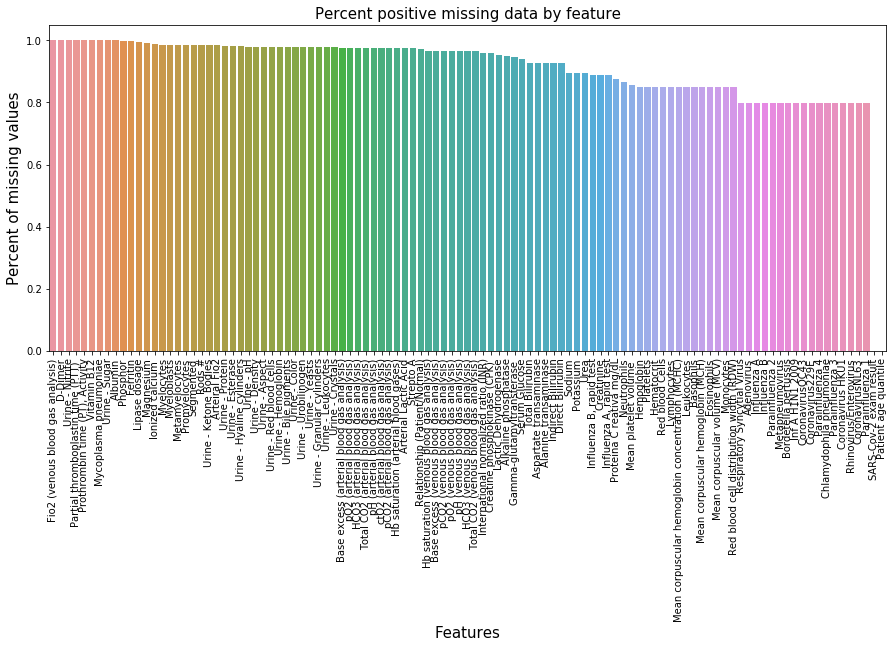

In [14]:
dataset_positive = dataset[dataset['SARS-Cov-2 exam result'] == 1]
missing_data_positive = get_missing_data(dataset_positive)

plot_missing_data(missing_data_positive, 'Percent positive missing data by feature')
missing_data_positive.head(10)

,Total,Percent
Urine - Sugar,5086,1.000000
Partial thromboplastin time (PTT),5086,1.000000
Urine - Nitrite,5086,1.000000
"Prothrombin time (PT), Activity",5086,1.000000
Mycoplasma pneumoniae,5086,1.000000
D-Dimer,5086,1.000000
Fio2 (venous blood gas analysis),5085,0.999803
Vitamin B12,5083,0.999410
Lipase dosage,5081,0.999017
Arteiral Fio2,5075,0.997837


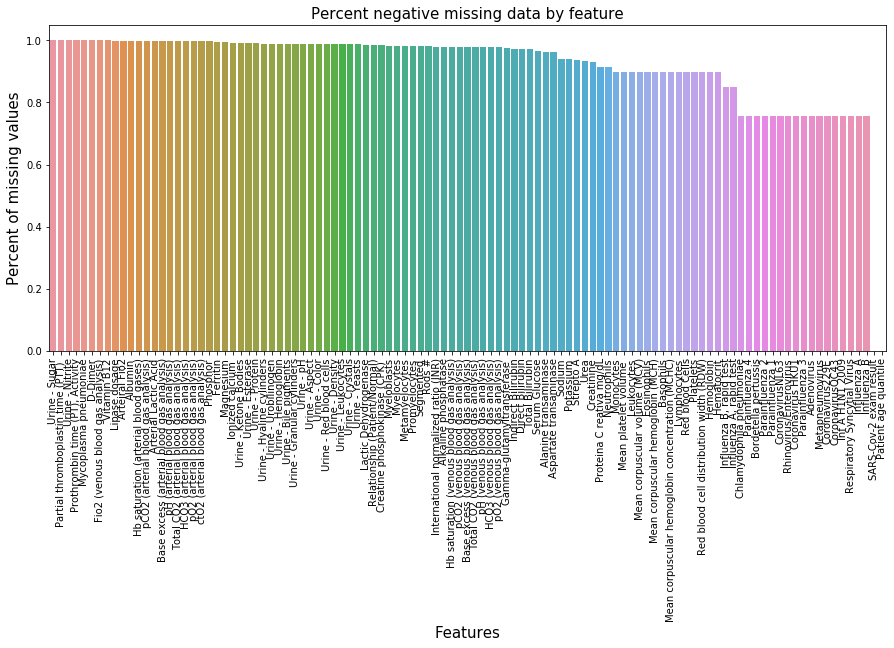

In [15]:
dataset_negative = dataset[dataset['SARS-Cov-2 exam result'] == 0]
missing_data_negative = get_missing_data(dataset_negative)

plot_missing_data(missing_data_negative, 'Percent negative missing data by feature')
missing_data_negative.head(10)

## Correlation Matrix

In [16]:
corrmat = abs(dataset.corr())

In [17]:
# Correlation with output variable
cor_target = corrmat["SARS-Cov-2 exam result"]
# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15].index.tolist()

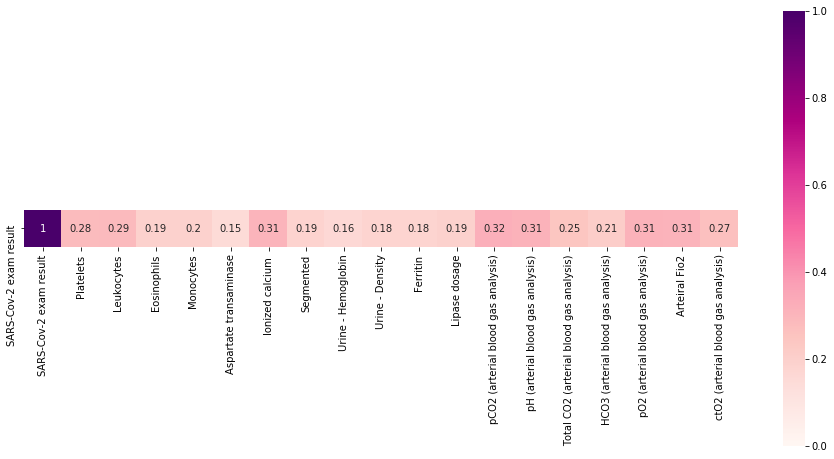

In [18]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(abs(dataset[relevant_features].corr().iloc[0:1, :]), yticklabels=[relevant_features[0]], xticklabels=relevant_features, vmin = 0.0, square=True, annot=True, vmax=1.0, cmap='RdPu')

## Negative and Positive Cases

In [19]:
nof_positive_cases = len(dataset_positive.index)
nof_negative_cases = len(dataset_negative.index)

(-1.1076132200227402,
 1.106918589509273,
 -1.1043893148273538,
 1.1002090207918012)

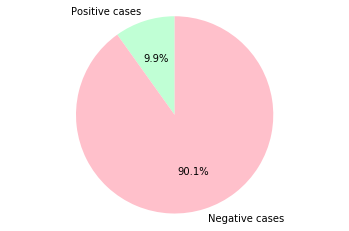

In [20]:
fig1, ax1 = plt.subplots()
ax1.pie([nof_positive_cases, nof_negative_cases], labels=['Positive cases', 'Negative cases'], autopct='%1.1f%%', startangle=90, colors=['#c0ffd5', '#ffc0cb'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

## Dealing with missing values and imbalanced data

First of all, we chose to drop the features with more than 95% of NaN values.

In [21]:
columns_to_exclude = missing_data.index[missing_data['Percent'] > 0.95].tolist()
dataset.drop(columns=columns_to_exclude, inplace=True)

# Redefine dataset positive and negative
dataset_negative = dataset[dataset['SARS-Cov-2 exam result'] == 0]
dataset_positive = dataset[dataset['SARS-Cov-2 exam result'] == 1]

As can be seen from the pie chart above, the dataset is highly imbalanced. We tried to train some models with the imbalanced data, but the results achieved were around 6% of recall. Then, in order to balance the dataset we chose to keep only the rows with at least 20 non-NaN values.

In [22]:
dataset_negative = dataset_negative.dropna(axis=0, thresh=20)

### Negative and Positive cases

Below, we can see the percentage of negative and positive cases after under-sampling.

In [23]:
X = pd.concat([dataset_negative, dataset_positive])

In [24]:
nof_positive_cases = len(dataset_positive.index)
nof_negative_cases = len(dataset_negative.index)

(-1.1255258618684574,
 1.111882808337921,
 -1.1106755071155912,
 1.1005083574816947)

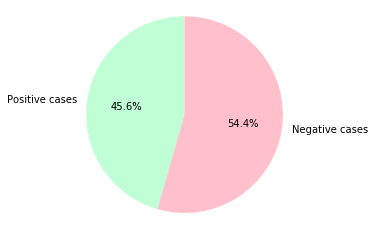

In [25]:
fig1, ax1 = plt.subplots()
ax1.pie([nof_positive_cases, nof_negative_cases], labels=['Positive cases', 'Negative cases'], autopct='%1.1f%%', startangle=90, colors=['#c0ffd5', '#ffc0cb'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

### Correlation Matrix

In [26]:
corrmat = abs(X.corr())

In [27]:
# Correlation with output variable
cor_target = corrmat["SARS-Cov-2 exam result"]
# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15].index.tolist()

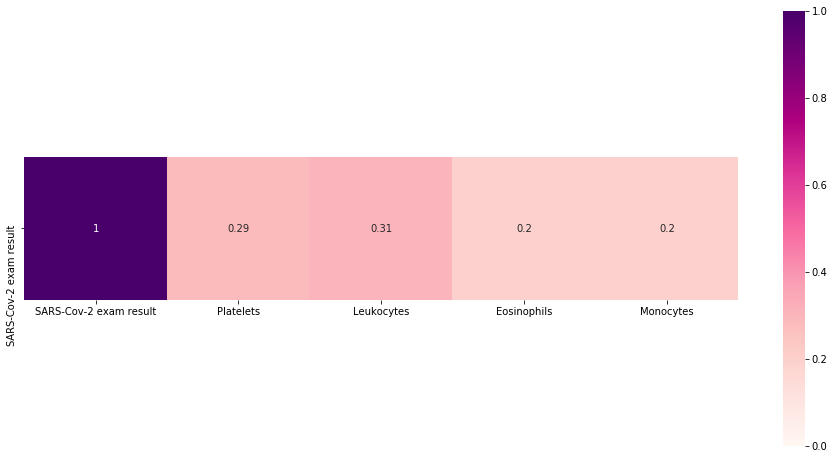

In [28]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(abs(X[relevant_features].corr().iloc[0:1, :]), yticklabels=[relevant_features[0]], xticklabels=relevant_features, vmin = 0.0, square=True, annot=True, vmax=1.0, cmap='RdPu')

## Training to Predict COVID-19

### Define features and target

In [29]:
X = X[relevant_features]
y = X['SARS-Cov-2 exam result']
X.drop(columns=['SARS-Cov-2 exam result'], inplace=True)

### Random Forest

First, we split the dataset into train and test set.

In [30]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Then, we imput the median values into the NaN values.

In [31]:
imp = SimpleImputer(strategy='median')
imp = imp.fit(X)

Finally, we trained the random forest classifier using scikit-learn and 10-fold cross validation.

In [32]:
rfc = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc, imp.transform(X_train_rf), y_train_rf, cv=10, scoring='recall')
scores

array([0.86363636, 0.95454545, 0.95454545, 0.93181818, 0.86666667,
       0.86666667, 0.71111111, 0.95555556, 0.8       , 0.97777778])

In [33]:
print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Recall: 0.89 (+/- 0.16)
